<a href="https://colab.research.google.com/github/flohmannjr/tensorflow_curso/blob/main/TensorFlow_MP2_1_SkimLit%2B.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Milestone Project 2.1: SkimLit+

Esta é a continuidade do projeto SkimLit, segundo milestone project do curso TensorFlow Developer Certificate in 2023: Zero to Mastery. https://www.udemy.com/share/104ssS3@m--2vC9jNX6kIapUf0IUOOxnuj8_1SisbHiZTsJDQ5z2toWaLfaenc4bvZ4i2Yd5/

# Importações

In [1]:
import tensorflow as tf
import tensorflow_hub as hub

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow.data import AUTOTUNE, Dataset
from tensorflow.keras import Model
from tensorflow.keras.layers import Bidirectional, Concatenate, Dense, Dropout, Embedding, Input, LSTM, TextVectorization
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model

from sklearn.preprocessing import LabelEncoder, OneHotEncoder

# Configurações, constantes e variáveis globais

In [2]:
plt.rcParams['figure.figsize'] = [8, 5]
plt.rcParams['figure.dpi'] = 100

plt.style.use('seaborn-darkgrid')

COR = '#007f66'

DIRETORIO = '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign'

LIMITE_CARACTERES = 80

LIMITE_INCORPORADOR = 300
LIMITE_INCORPORADOR_CARACTERES = 25
LIMITE_VETOR_TEXTO = 100

LOTE_TAMANHO = 32

ENTRADA_FORMATO = (1,)
ENTRADA_TIPO = tf.string

ATIVACAO_CNN = 'relu'
ATIVACAO_RNN = 'tanh'
ATIVACAO_SAIDA = 'softmax'

SUAVIZACAO = 0.2
APRENDIZADO = 0.001
METRICAS = ['accuracy']

ITERACOES = 5

avaliacoes = [None] * 6

# Funções

In [3]:
!wget https://raw.githubusercontent.com/flohmannjr/tensorflow_curso/main/funcoes.py

--2023-02-01 15:36:37--  https://raw.githubusercontent.com/flohmannjr/tensorflow_curso/main/funcoes.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7753 (7.6K) [text/plain]
Saving to: ‘funcoes.py’

funcoes.py          100%[===================>]   7.57K  --.-KB/s    in 0s      

2023-02-01 15:36:38 (82.5 MB/s) - ‘funcoes.py’ saved [7753/7753]



In [4]:
from funcoes import avaliar_modelo, grafico_historico_por_iteracao, preprocessar_texto

# Dados

In [5]:
!git clone https://github.com/Franck-Dernoncourt/pubmed-rct.git

Cloning into 'pubmed-rct'...
remote: Enumerating objects: 33, done.
remote: Counting objects: 100% (8/8), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 33 (delta 5), reused 5 (delta 5), pack-reused 25
Unpacking objects: 100% (33/33), 177.08 MiB | 7.81 MiB/s, done.


In [6]:
df_treino    = pd.DataFrame(preprocessar_texto(f'{DIRETORIO}/train.txt'))
df_validacao = pd.DataFrame(preprocessar_texto(f'{DIRETORIO}/dev.txt'))

codificador_onehot = OneHotEncoder(sparse=False)

rotulos_onehot_treino    = codificador_onehot.fit_transform(df_treino['classe'].to_numpy().reshape(-1, 1))
rotulos_onehot_validacao = codificador_onehot.transform(df_validacao['classe'].to_numpy().reshape(-1, 1))

codificador_int = LabelEncoder()

rotulos_int_treino    = codificador_int.fit_transform(df_treino['classe'].to_numpy())
rotulos_int_validacao = codificador_int.transform(df_validacao['classe'].to_numpy())

classes = codificador_int.classes_

caracteres_por_texto_98 = int(np.percentile([len(texto) for texto in df_treino['texto']], 98))

lista_caracteres_treino    = [" ".join(list(texto)) for texto in df_treino['texto']]
lista_caracteres_validacao = [" ".join(list(texto)) for texto in df_validacao['texto']]

numero_linha_98 = int(np.percentile(df_treino['numero'], 98))

linhas_numero_onehot_treino    = tf.one_hot(df_treino['numero'], depth=numero_linha_98)
linhas_numero_onehot_validacao = tf.one_hot(df_validacao['numero'], depth=numero_linha_98)

total_linhas_98 = int(np.percentile(df_treino['total'], 98))

linhas_total_onehot_treino    = tf.one_hot(df_treino['total'], depth=total_linhas_98)
linhas_total_onehot_validacao = tf.one_hot(df_validacao['total'], depth=total_linhas_98)

dados_hibridos_linhas_treino_textos  = Dataset.from_tensor_slices((df_treino['texto'], lista_caracteres_treino, linhas_numero_onehot_treino, linhas_total_onehot_treino))
dados_hibridos_linhas_treino_rotulos = Dataset.from_tensor_slices(rotulos_onehot_treino)
dados_hibridos_linhas_treino         = Dataset.zip((dados_hibridos_linhas_treino_textos, dados_hibridos_linhas_treino_rotulos))
dados_hibridos_linhas_treino         = dados_hibridos_linhas_treino.batch(LOTE_TAMANHO).prefetch(AUTOTUNE)

dados_hibridos_linhas_validacao_textos  = Dataset.from_tensor_slices((df_validacao['texto'], lista_caracteres_validacao, linhas_numero_onehot_validacao, linhas_total_onehot_validacao))
dados_hibridos_linhas_validacao_rotulos = Dataset.from_tensor_slices(rotulos_onehot_validacao)
dados_hibridos_linhas_validacao         = Dataset.zip((dados_hibridos_linhas_validacao_textos, dados_hibridos_linhas_validacao_rotulos))
dados_hibridos_linhas_validacao         = dados_hibridos_linhas_validacao.batch(LOTE_TAMANHO).prefetch(AUTOTUNE)

# Camadas auxiliares

In [7]:
vetorizador_caracteres = TextVectorization(max_tokens=LIMITE_CARACTERES,
                                           output_mode='int',
                                           output_sequence_length=caracteres_por_texto_98,
                                           name='vetorizador_caracteres')

vetorizador_caracteres.adapt(lista_caracteres_treino)

vocabulario_caracteres = vetorizador_caracteres.get_vocabulary()

incorporador_caracteres = Embedding(input_dim=len(vocabulario_caracteres),
                                    output_dim=LIMITE_INCORPORADOR_CARACTERES,
                                    mask_zero=True,
                                    input_length=caracteres_por_texto_98,
                                    name='incorporador_caracteres')

incorporador_use = hub.KerasLayer(handle='https://tfhub.dev/google/universal-sentence-encoder/4',
                                  trainable=False,
                                  name='incorporador_use')

# Modelo 0: Modelo 5 do projeto original

## Modelo com incorporação de palavras

In [8]:
modelo_nome = 'modelo_incorporacao_palavras'

entradas = Input(shape=[], dtype=ENTRADA_TIPO, name='camada_entrada_palavras')

incorporador = incorporador_use(entradas)

saidas = Dense(LIMITE_INCORPORADOR, activation=ATIVACAO_CNN, name='camada_relu_palavras')(incorporador)

modelo_incorporacao_palavras = Model(inputs=entradas, outputs=saidas, name=modelo_nome)

## Modelo com incorporação de caracteres

In [9]:
modelo_nome = 'modelo_incorporacao_caracteres'

entradas = Input(shape=ENTRADA_FORMATO, dtype=ENTRADA_TIPO, name='camada_entrada_caracteres')

camadas = vetorizador_caracteres(entradas)
camadas = incorporador_caracteres(camadas)

saidas = Bidirectional(layer=LSTM(units=LIMITE_INCORPORADOR_CARACTERES, activation=ATIVACAO_RNN), name='camada_bi_lstm_caracteres')(camadas)

modelo_incorporacao_caracteres = Model(inputs=entradas, outputs=saidas, name=modelo_nome)

## Combinação dos modelos de incorporação

In [10]:
combinacao_incorporacao = Concatenate(name="camada_combinacao_incorporacao")([modelo_incorporacao_palavras.output,
                                                                              modelo_incorporacao_caracteres.output])

## Camadas de abandono

In [11]:
abandonos_incorporacao = Dense(LIMITE_VETOR_TEXTO * 2, activation=ATIVACAO_CNN, name='camada_abandonos_incorporacao_relu')(combinacao_incorporacao)
abandonos_incorporacao = Dropout(rate=0.5, name='camada_abandonos_incorporacao')(abandonos_incorporacao)

## Modelo para o número de linhas

In [12]:
modelo_nome = 'modelo_numero_linhas'

entradas = Input(shape=(numero_linha_98,), dtype=linhas_numero_onehot_treino.dtype, name='camada_entrada_numero_linhas')

saidas = Dense(numero_linha_98 * 2, activation=ATIVACAO_CNN, name='camada_relu_numero_linhas')(entradas)

modelo_numero_linhas = Model(inputs=entradas, outputs=saidas, name=modelo_nome)

## Modelo para o total de linhas

In [13]:
modelo_nome = 'modelo_total_linhas'

entradas = Input(shape=(total_linhas_98,), dtype=linhas_total_onehot_treino.dtype, name='camada_entrada_total_linhas')

saidas = Dense(total_linhas_98 * 2, activation=ATIVACAO_CNN, name='camada_relu_total_linhas')(entradas)

modelo_total_linhas = Model(inputs=entradas, outputs=saidas, name=modelo_nome)

## Combinação dos modelos de incorporação e linhas

In [14]:
combinacao_linhas = Concatenate(name="camada_combinacao_linhas")([abandonos_incorporacao,
                                                                  modelo_numero_linhas.output,
                                                                  modelo_total_linhas.output])

## Camadas de abandono e saída

In [15]:
abandonos_linhas = Dense(LIMITE_VETOR_TEXTO * 2, activation=ATIVACAO_CNN, name='camada_abandonos_linhas_relu')(combinacao_linhas)
abandonos_linhas = Dropout(rate=0.5, name='camada_abandonos_linhas')(abandonos_linhas)

saidas = Dense(len(classes), activation=ATIVACAO_SAIDA, name='camada_saida')(abandonos_linhas)

## Modelo com incorporação híbrida e linhas

In [16]:
modelo_nome = 'modelo_0_modelo_5_original'

modelo = Model(inputs=[modelo_incorporacao_palavras.input,
                       modelo_incorporacao_caracteres.input,
                       modelo_numero_linhas.input,
                       modelo_total_linhas.input],
               outputs=saidas,
               name=modelo_nome)

## Verificação do modelo

In [17]:
modelo.summary()

Model: "modelo_0_modelo_5_original"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 camada_entrada_caracteres (Inp  [(None, 1)]         0           []                               
 utLayer)                                                                                         
                                                                                                  
 camada_entrada_palavras (Input  [(None,)]           0           []                               
 Layer)                                                                                           
                                                                                                  
 vetorizador_caracteres (TextVe  (None, 347)         0           ['camada_entrada_caracteres[0][0]
 ctorization)                                                    ']      

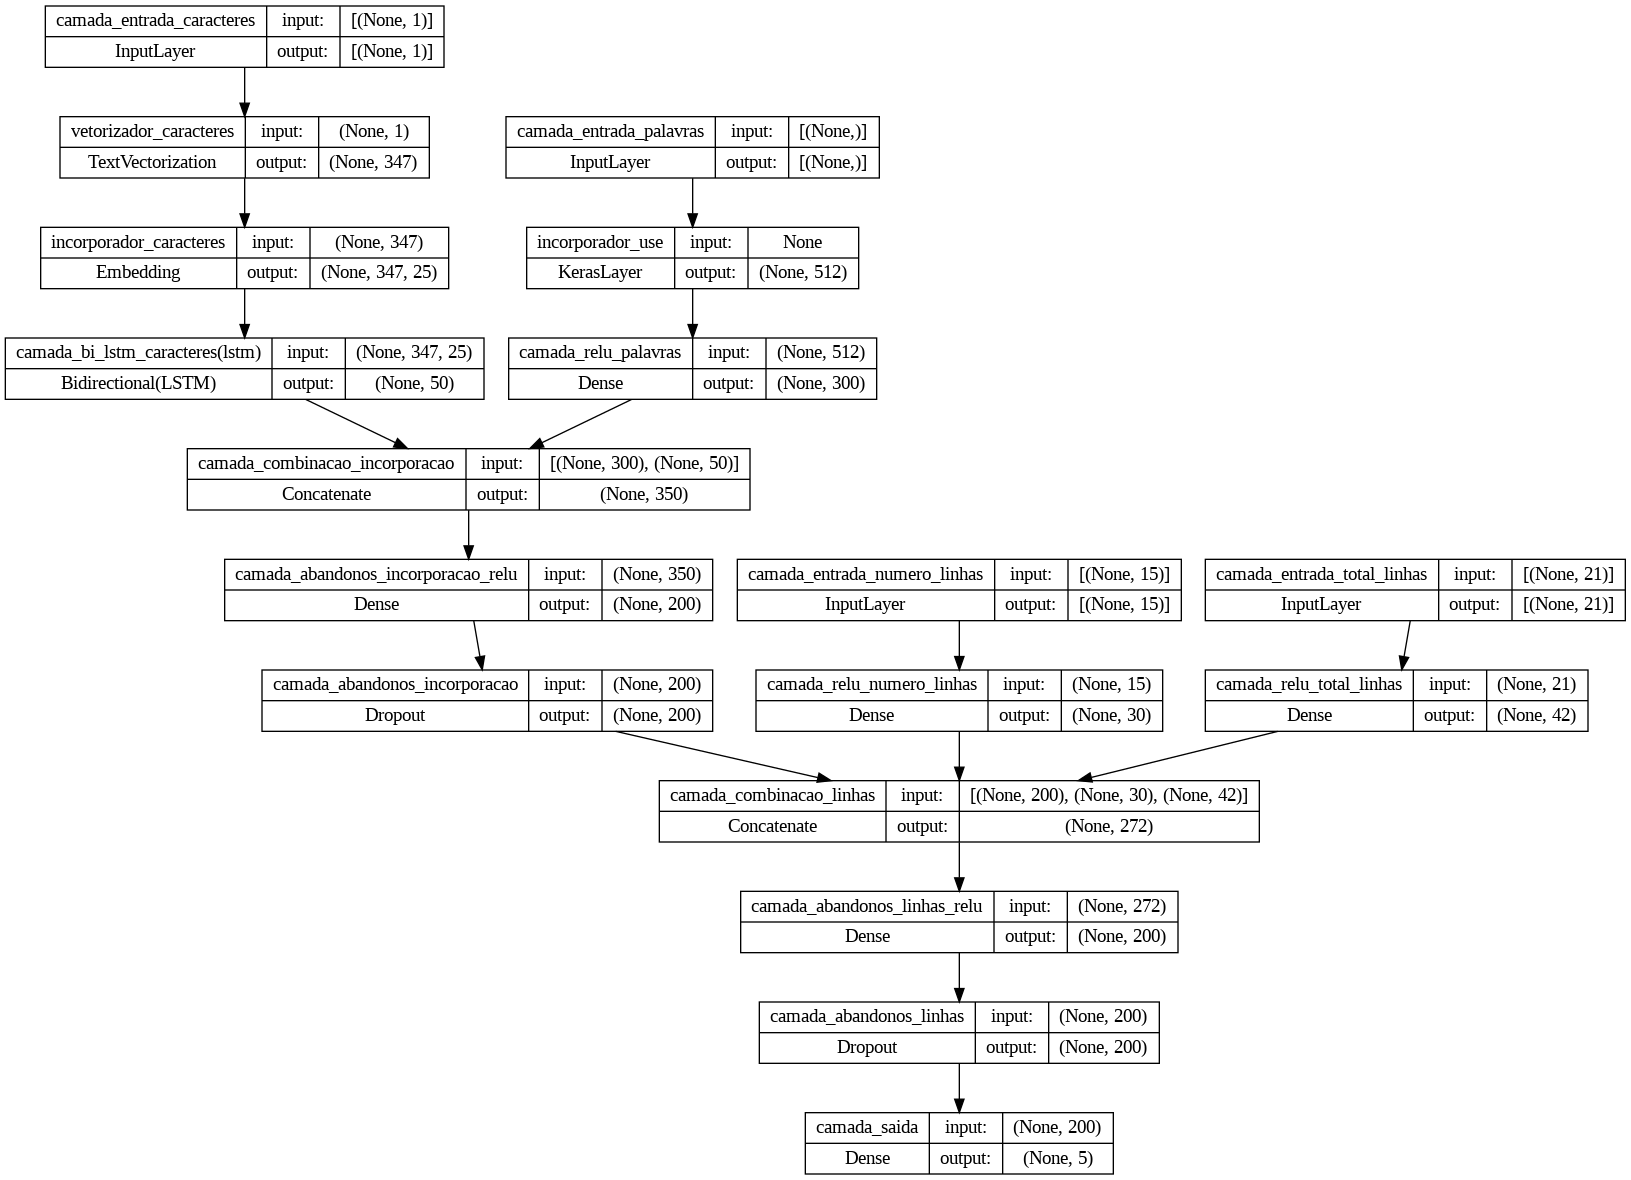

In [18]:
plot_model(modelo, show_shapes=True)

## Compilação com suavização de rótulo

In [19]:
modelo.compile(loss=CategoricalCrossentropy(label_smoothing=SUAVIZACAO),
               optimizer=Adam(learning_rate=APRENDIZADO),
               metrics=METRICAS)

## Finalização do modelo

In [20]:
historico = modelo.fit(dados_hibridos_linhas_treino,
                       epochs=ITERACOES,
                       validation_data=dados_hibridos_linhas_validacao,
                       verbose=1)

Epoch 1/5
5627/5627 [==============================] - 290s 49ms/step - loss: 0.9320 - accuracy: 0.8334 - val_loss: 0.8630 - val_accuracy: 0.8681
Epoch 2/5
5627/5627 [==============================] - 273s 49ms/step - loss: 0.8842 - accuracy: 0.8655 - val_loss: 0.8557 - val_accuracy: 0.8728
Epoch 3/5
5627/5627 [==============================] - 273s 48ms/step - loss: 0.8703 - accuracy: 0.8760 - val_loss: 0.8545 - val_accuracy: 0.8716
Epoch 4/5
5627/5627 [==============================] - 281s 50ms/step - loss: 0.8595 - accuracy: 0.8840 - val_loss: 0.8578 - val_accuracy: 0.8707
Epoch 5/5
5627/5627 [==============================] - 276s 49ms/step - loss: 0.8499 - accuracy: 0.8902 - val_loss: 0.8587 - val_accuracy: 0.8688


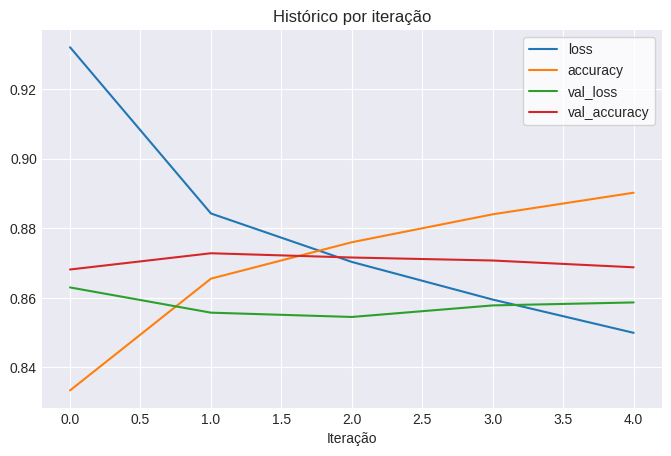

In [21]:
grafico_historico_por_iteracao(historico)

945/945 [==============================] - 22s 21ms/step
              precision    recall  f1-score   support

  BACKGROUND       0.70      0.87      0.78      3449
 CONCLUSIONS       0.93      0.85      0.89      4582
     METHODS       0.92      0.91      0.91      9964
   OBJECTIVE       0.83      0.49      0.61      2376
     RESULTS       0.88      0.92      0.90      9841

    accuracy                           0.87     30212
   macro avg       0.85      0.81      0.82     30212
weighted avg       0.87      0.87      0.87     30212



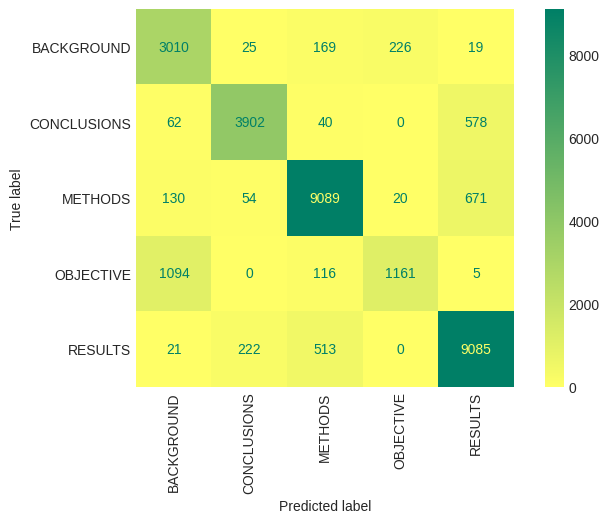

In [22]:
probabilidades = modelo.predict(dados_hibridos_linhas_validacao)
previsoes      = tf.argmax(probabilidades, axis=1)
avaliacoes[0]  = avaliar_modelo(rotulos_int_validacao, previsoes, classes)

In [23]:
avaliacoes[0]

{'acuracia': 0.8687607573149742,
 'precisao': 0.8729526793046232,
 'revocacao': 0.8687607573149742,
 'pontuacao-f1': 0.8659033563426276}

# Comparação de modelos

In [24]:
avaliacoes = [a for a in avaliacoes if a is not None]

comparacao = pd.DataFrame(avaliacoes)
comparacao = comparacao.reset_index().melt(id_vars='index').rename(columns=str.title)

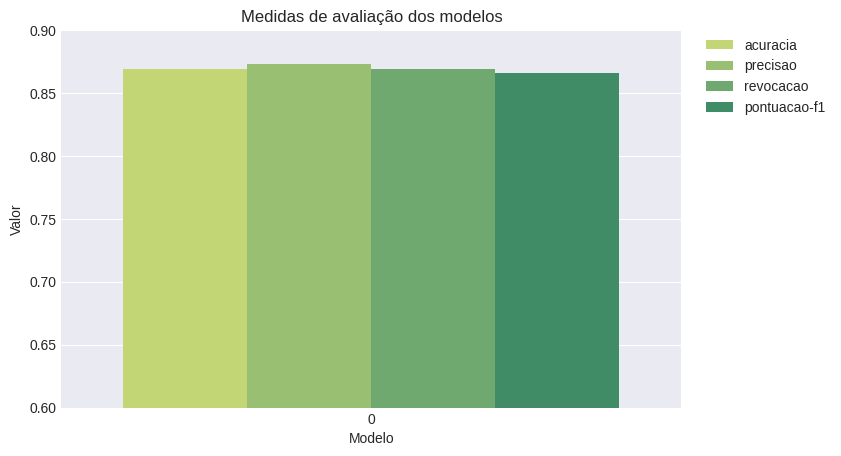

In [25]:
sns.barplot(data=comparacao, x='Index', y='Value', hue='Variable', palette='summer_r')

plt.ylim(0.60, 0.90)

plt.title('Medidas de avaliação dos modelos')
plt.xlabel('Modelo')
plt.ylabel('Valor')

plt.legend(loc=(1.03, 0.76));

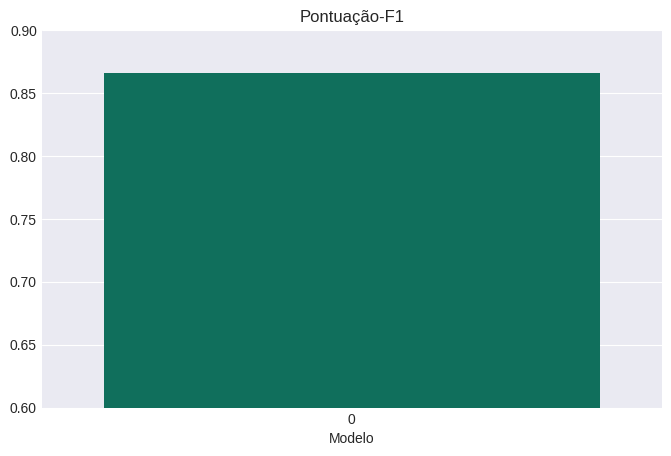

In [26]:
comparacao_f1 = pd.DataFrame([a['pontuacao-f1'] for a in avaliacoes]).T

sns.barplot(data=comparacao_f1, color=COR)

plt.ylim(0.60, 0.90)

plt.title('Pontuação-F1')
plt.xlabel('Modelo')
plt.ylabel('');